In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10
from tqdm import tqdm_notebook as tqdm
from torchvision.utils import save_image, make_grid
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
import numpy as np
from IPython import display
import requests
from io import BytesIO
from PIL import Image
from PIL import Image, ImageSequence
from IPython.display import HTML
import warnings
from matplotlib import rc
import gc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
gc.enable()
plt.ioff()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
cd gdrive/MyDrive/UChicago/Academics/Computer Science/TTIC 31230/Final Project/vqvae_modified2

/content/gdrive/.shortcut-targets-by-id/1X28loE-F3vl4_iI9qGeFmIZC-kNS-9iV/UChicago/Academics/Computer Science/TTIC 31230/Final Project/vqvae_modified2


In [3]:
num_classes = 10
resnet = resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
resnet_ = list(resnet.children())[:-2]
resnet_[3] = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
classifier = nn.Conv2d(512,num_classes,1)
torch.nn.init.kaiming_normal_(classifier.weight)
resnet_.append(classifier)
resnet_.append(nn.Upsample(size=32, mode='bilinear', align_corners=False))
tiny_resnet = nn.Sequential(*resnet_)
model = nn.DataParallel(tiny_resnet).cuda()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
model.load_state_dict(torch.load('./models/seg_model.pt'))

<All keys matched successfully>

In [8]:
def attention(x):
    return torch.sigmoid(torch.logsumexp(x, 1, keepdim=True))

In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10(root='.', train=True, download=True, transform=transform_train)
train_iter = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

testset = CIFAR10(root='.', train=False, download=True, transform=transform_test)
test_iter = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
num_epochs = 6
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 78, eta_min=0.001)

losses = []
acces = []
v_losses = []
v_acces = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    acc = 0.0
    var = 0.0
    model.train()

    for i, (x, _label) in enumerate(train_iter):
        x = x.cuda()
        _label = _label.cuda()
        label = F.one_hot(_label).float()
        seg_out = model(x)
        
        attn = attention(seg_out)
        # Smooth Max Aggregation
        logit = torch.log(torch.exp(seg_out*0.5).mean((-2,-1)))*2
        loss = criterion(logit, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        epoch_loss += loss.item()
        acc += (logit.argmax(-1)==_label).sum()
        
    avg_loss = epoch_loss / (i + 1)
    losses.append(avg_loss)
    avg_acc = acc.cpu().detach().numpy() / (len(trainset))
    acces.append(avg_acc)

    # model.eval()
    # epoch_loss = 0.0
    # acc = 0.0
    # num_seen = 0

    # for i, (x, _label) in enumerate(test_iter):
    #     x = x.cuda()
    #     _label = _label.cuda()
    #     label = F.one_hot(_label).float()
    #     seg_out = model(x)
    #     attn = attention(seg_out)
    #     logit = torch.log(torch.exp(seg_out*0.5).mean((-2,-1)))*2
    #     loss = criterion(logit, label)
    #     epoch_loss += loss.item()
    #     acc += (logit.argmax(-1)==_label).sum()
    #     num_seen += label.size(0)
    
    # avg_loss_val = epoch_loss / (i + 1)
    # v_losses.append(avg_loss_val)
    # avg_acc_val = acc.cpu().detach().numpy() / (len(testset))
    # v_acces.append(avg_acc_val)

    print('Epoch {}:'.format(epoch))
    print('Train loss: {:.3f}, Train accuracy: {:.3f}'.format(avg_loss, avg_acc))
    # print('Test loss: {:.3f}, Test accuracy: {:.3f}'.format(avg_loss_val, avg_acc_val))

Epoch 0:
Train loss: 0.059, Train accuracy: 0.891
Epoch 1:
Train loss: 0.052, Train accuracy: 0.906
Epoch 2:
Train loss: 0.046, Train accuracy: 0.918
Epoch 3:
Train loss: 0.041, Train accuracy: 0.926
Epoch 4:
Train loss: 0.038, Train accuracy: 0.933
Epoch 5:
Train loss: 0.034, Train accuracy: 0.939


In [80]:
model.eval()
for i, (x_batch, label) in enumerate(test_iter):
  if i == 50:
    x = x_batch.cuda()
    seg_out = model(x)
    attn = attention(seg_out)

In [70]:
attn = torch.reshape(attn, (100, 32, 32))

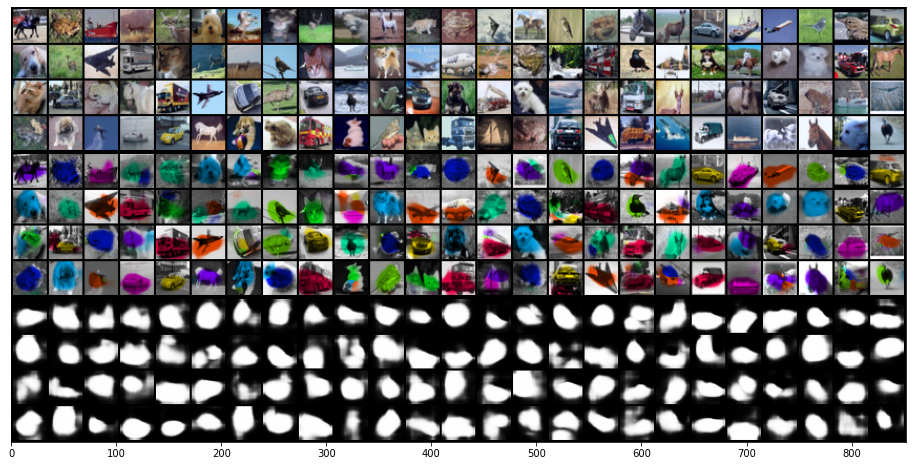

In [ ]:
conf = torch.max(nn.functional.softmax(seg_out, dim=1), dim=1)[0]
hue = (torch.argmax(seg_out, dim=1).float() + 0.5)/10

x -= x.min()
x /= x.max()
gs_im = x.mean(1)
gs_min = gs_im.min()
gs_max = torch.max((gs_im-gs_min))
gs_im = (gs_im - gs_min)/gs_max

hsv_im = torch.stack((hue.float(), attn.squeeze().float(), gs_im.float()), -1)
im = hsv_to_rgb(hsv_im.cpu().detach().numpy())
ex = make_grid(torch.tensor(im).permute(0,3,1,2), normalize=True, nrow=25)

attns = make_grid(attn, normalize=False, nrow=25).cpu().detach()
inputs = make_grid(x, normalize=True, nrow=25).cpu().detach()

display.clear_output(wait=True)
plt.figure(figsize=(20,8))
plt.imshow(np.concatenate((inputs.numpy().transpose(1,2,0), 
                           ex.numpy().transpose(1,2,0), 
                           attns.numpy().transpose(1,2,0)), axis=0))

plt.yticks([])
display.display(plt.gcf())

In [ ]:
# torch.save(model.state_dict(), './seg_model.pt')

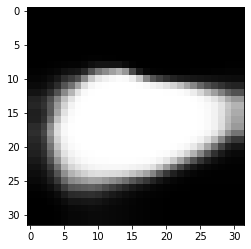

In [11]:
attn = attn.cpu().detach().numpy()

plt.imshow(attn[0], cmap='gray')
display.display(plt.gcf())

In [82]:
attn = attn.repeat(1, 3, 1, 1)

In [84]:
z = torch.sum(attn, dim=(1, 2, 3))

In [86]:
z = torch.reshape(z, (-1, 1, 1, 1))

In [88]:
attn = attn / z

In [90]:
torch.sum(attn, dim=(1, 2, 3))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<SumBackward1>)

In [ ]:
im.shape

(100, 32, 32, 3)

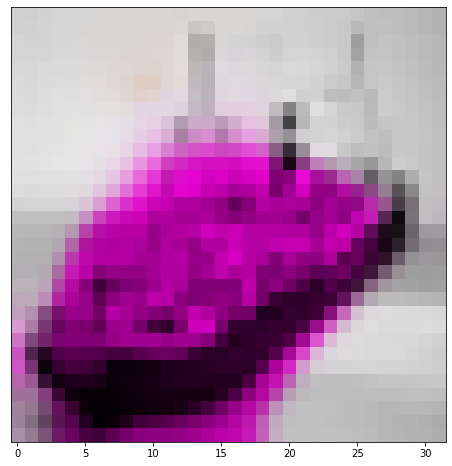

In [ ]:
plt.imshow(im[20])
display.display(plt.gcf())

In [ ]:
# adding a segmentation channel to the input X
x_cpu = x.cpu().detach().numpy()
attn_cpu = attn.cpu().detach().numpy()

x_seg = np.concatenate((x_cpu, attn_cpu), axis=1)
x_seg.shape

(100, 4, 32, 32)